# Introduction to pytorch tensors

---

Pytorch tensors, work very similar to numpy arrays and you can always convert it to a numpy array or make a numpy array into a torch tensor. The primary difference is that it is located either on your CPU or your GPU and that it contains works with the auto differential software of pytorch.

In [172]:
import torch
x_tensor = torch.tensor([[1., -1.], [1., -1.]])
print(type(x_tensor))

# tensor to numpy
x_array = x_tensor.numpy()
print(type(x_array))

# numpy to tensor
x_tensor2 =torch.tensor(x_array)
print(type(x_tensor2))

print(x_tensor2 == x_tensor)

# Location of tensor
x_tensor.device

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
tensor([[True, True],
        [True, True]])


device(type='cpu')

### Example of finding gradient

In [173]:
x = torch.tensor([[1., -1.], [1., 1.]], requires_grad=True)

# sum(x_i ^ 2)
out = (x**2).sum()

# calculate the gradient 
out.backward()

# What is the gradient for x
print(x.grad)

tensor([[ 2., -2.],
        [ 2.,  2.]])


# Optimizing a polynomial

---



In [174]:
x = torch.tensor([3.], requires_grad=True)
y = 2. + x**2 -3 *x
print(y)

# create sgd optimizer
optimizer = torch.optim.SGD([x], lr=0.01)

# backward pass / calcuate the gradient on the thing we want to optimize
y.backward()

print(x.grad) # examine

# step in the direction to minimize y
optimizer.step()

# set the gradient to zero. (This is a bit wierd but required)
optimizer.zero_grad()


tensor([2.], grad_fn=<SubBackward0>)
tensor([3.])


In [175]:
# we see that x have improved (minimum is 1.5 so moving in the right direction)
print(x)
# we see that the gradient is set to zero
print(x.grad)

tensor([2.9700], requires_grad=True)
tensor([0.])


We can now do this multiple times to obtain the desired results:

In [176]:
for i in range(1000):

    # forward pass / or just calculate the outcome
    y = 2. + x**2 -3 *x

    # backward pass on the thing we want to minimize
    y.backward()

    # take a step in the "minimize direction"
    optimizer.step()

    # zero the gradient
    optimizer.zero_grad()

In [177]:
print(x)

tensor([1.5000], requires_grad=True)



# Fitting a Linear regression

---

Here we will fit a linear regression using pytorch, using the same approach as above.

## 0) Prepare the data
First let us create some data. We will do this using `sklearn`'s `make_regression`, which just make some sample data for regression.

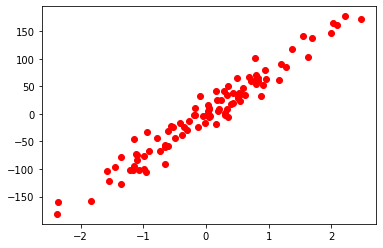

torch.Size([100, 1])
torch.float32
torch.float32


In [178]:
from sklearn import datasets
import matplotlib.pyplot as plt

# 0) Prepare data
X_numpy, y_numpy = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=4)

# plot the sample
plt.plot(X_numpy, y_numpy, 'ro')
plt.show()

# cast to float Tensor
X = torch.tensor(X_numpy, dtype=torch.float)
y = torch.tensor(y_numpy, dtype=torch.float)
y = y.view(y.shape[0], 1) # view is similar to reshape it simply sets the desired shape to (100, 1)
print(y.shape)
print(y.dtype)
print(x.dtype)


n_samples, n_features = X.shape

## 1) Creating the linear model
You can do this using a the `nn.Linear`. This corresponds to multiplying with a matrix of beta coefficients (or weights in a neural network sense) and adding a bias. 

> Actually if you are very pedantic it is not really a linear transformation but an *affine* transformation, but it corresponds to what we think of as linear (regression).

In [179]:
from torch import nn
# 1) Model
# Linear model f = wx + b
input_size = n_features 
output_size = 1
model = nn.Linear(input_size, output_size)

# 2) Loss and optimizer
Here we will create the optimizer, note we use `model.parameters` to get a list to get all of the parameters of the model.

We also use the `MSELoss()` as our criterion to minimize. It is simply the mean squared error (MSE) which you are used to from regression.

In [180]:
learning_rate = 0.01 # feel free to change this

print(list(model.parameters())) # only two parameters a beta and an intercept

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

[Parameter containing:
tensor([[0.8709]], requires_grad=True), Parameter containing:
tensor([0.6985], requires_grad=True)]


## 3) Training loop
Well this is essentially the same as before:

In [181]:
epochs = 500
for epoch in range(epochs):
    # Forward pass / calc predicted y
    y_predicted = model(X)

    # calucate loss / MSE
    loss = criterion(y_predicted, y)
    
    # Backward pass / gradient and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    # some print to see that it is running
    if (epoch+1) % 100 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 100, loss = 408.6332
epoch: 200, loss = 292.8041
epoch: 300, loss = 290.2195
epoch: 400, loss = 290.1611
epoch: 500, loss = 290.1598


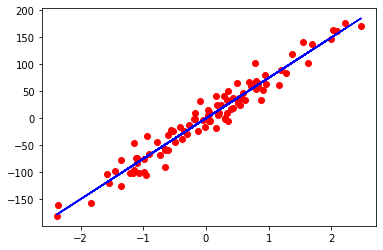

In [182]:
# Plot
predicted = model(X).detach().numpy()

plt.plot(X_numpy, y_numpy, 'ro')
plt.plot(X_numpy, predicted, 'b')
plt.show()

<details>
    <summary> Hmm this seems like something we should do in a class? (or why didn't you introduce nn.modules?!) </summary>

You are completely right it does work much better as a class, but maybe slightly overdoing it for the task at hand, however if you are familiar with pytorch or deep learning you might find it more convenient to create a model class. We will look at this next time as well, but in pytorch this looks something like this for the linear regression:

```py
class LinearModel(nn.Module):
    def __init__(self, n_input_features):
        # initialize the superclass nn.module (to tell pytorch that this is a trainable model)
        super(Model, self).__init__()

        # create a linear layer to save in the model
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y = self.linear(x)
        return y
```

You can the use this model the same way as before:

```
model = LinearModel(n_input_features = 1) # create model
y = model.forward(x)

# same af before you can now calculate the loss and optimize in a loop
```

It is a little overkill for the exercise, but it might be nice getting used to the abstraction.

</details>

<br /> 


# Task: Logistic Regression

---

create a logistic regression, fitted either to your tekst features or (maybe easier to start with) the following test data.

Things which might be useful to know:

Torch do have a binary cross entropy loss function (`torch.nn.BCELoss`) and a sigmoid function (`torch.sigmoid`).

If you find it hard to start it might worth debating with your studygroup

- what the difference is between linear regression and logistic regression
- How many input features how many output?
- Try to draw it as a 1-layer neural network

> **Bonus**: The end of the chapter introduced the multinomial logistic regression, it is actually surprisingly easy to do in pytorch, can you implement it? (*Hint*: pytorch does have a softmax function) The chapter also introduces (L1 and) L2 regularization for logistic regression, can you add that to your model as well?

(1000, 10)


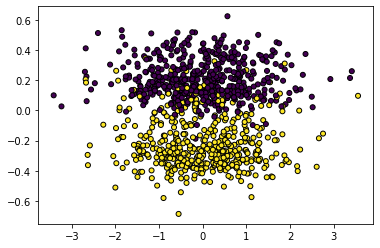

In [183]:
X_numpy, y_numpy = datasets.make_classification(n_samples=1000, n_features=10, random_state=7)

print(X_numpy.shape)

# only plotting 2 out of 10 feature
plt.scatter(X_numpy[:, 0], X_numpy[:, 1], marker='o', c=y_numpy,
            s=25, edgecolor='k')

In [184]:
# your code
# cast to float Tensor
X = torch.tensor(X_numpy, dtype=torch.float)
y = torch.tensor(y_numpy, dtype=torch.float)
y = y.view(y.shape[0], 1) # view is similar to reshape it simply sets the desired shape to (100, 1)
print(y.shape)
print(y.dtype)
print(x.dtype)


n_samples, n_features = X.shape


torch.Size([1000, 1])
torch.float32
torch.float32


In [185]:
from torch import nn
# 1) Model
# Linear model f = wx + b
input_size = n_features 
output_size = 1
model = nn.Linear(input_size, output_size)

In [186]:
learning_rate = 0.01 # feel free to change this

print(list(model.parameters())) # only two parameters a beta and an intercept

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

[Parameter containing:
tensor([[-0.2144,  0.1247, -0.0804, -0.2818,  0.2114, -0.2569,  0.2882, -0.1716,
          0.0183,  0.2133]], requires_grad=True), Parameter containing:
tensor([0.2854], requires_grad=True)]


In [187]:
epochs = 500
for epoch in range(epochs):
    # Forward pass / calc predicted y
    y_predicted = torch.sigmoid(model(X))

    # calucate loss / MSE
    loss = criterion(y_predicted, y)
    
    # Backward pass / gradient and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    # some print to see that it is running
    if (epoch+1) % 100 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 100, loss = 0.6154
epoch: 200, loss = 0.4661
epoch: 300, loss = 0.3881
epoch: 400, loss = 0.3421
epoch: 500, loss = 0.3124


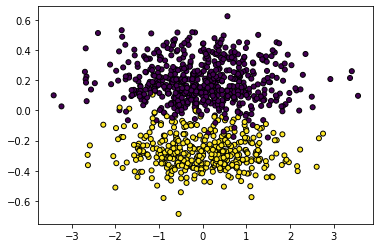

In [188]:
import numpy as np
# Plot
def categorize(x):
    if x >= 0.5:
        return 1
    else:
         return 0
predicted = model(X).detach().numpy()
ap = np.vectorize(categorize)
predicted = ap(predicted)

# only plotting 2 out of 10 feature
plt.scatter(X_numpy[:, 0],  X_numpy[:, 1], marker='o', c=predicted,
            s=25, edgecolor='k')